In [1]:
import findspark
findspark.init()

import wptools
import pyspark
import pyspark.sql
from pyspark.sql import *
import os.path
from pyspark.sql.functions import desc

from pyspark.sql import dataframe
from pyspark.sql import functions as F

from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql import SQLContext

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)
import seaborn as sns
import re

In [2]:
DATA_DIR = '../data/data_processed/'

In [3]:
popularity_civil_conflict_ = spark.read.parquet(DATA_DIR+"popularity_civil_conflict.parquet")

popularity_military_conflict_ = spark.read.parquet(DATA_DIR+"popularity_military_conflict.parquet")

# Pietro data
civil_conflict = spark.read.parquet(DATA_DIR+"wiki_civil_conflict_df.parquet")

civilian_attack = spark.read.parquet(DATA_DIR+'wiki_civilian_attack_df.parquet')

In [4]:
# Quantifying null values
# how many rows does the dataframe have?
mili_rows=civil_conflict.count()
from pyspark.sql.functions import isnan, when, count, col

mili_nan = civil_conflict.select([
    count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in civil_conflict.columns
]).toPandas()

mili_percentages_nan = mili_nan*100/mili_rows
mili_percentages_nan.head()

,id,death,end_date,location
0,0.0,76.859504,6.729634,4.368359


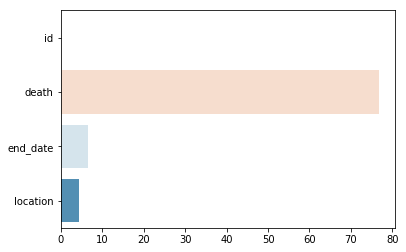

In [5]:
sns.barplot(data=mili_percentages_nan, palette='RdBu',orient='h')

In [6]:
civil_conflict.select('id','location').head(30)

[Row(id=33223959, location='[[Los Angeles]], [[California]], [[United States]]'),
 Row(id=33260618, location='[[Brightlingsea]], [[Essex]]'),
 Row(id=33285346, location='[[Portland, Oregon|Portland]], [[Oregon]]'),
 Row(id=33286705, location='[[San Jose, California|San Jose]], [[California]], [[United States]]'),
 Row(id=32438241, location='United States'),
 Row(id=32468135, location='[[Virden, Illinois]], [[United States]]'),
 Row(id=32487859, location='Northern Iraq'),
 Row(id=32490014, location='[[Walker County, Alabama]]'),
 Row(id=48303468, location='[Al-Hasakah Governorate (Q233914), Aleppo Governorate (Q214064)]'),
 Row(id=40891686, location='[[Vukovar]]<br/>[[Zagreb]]<br/>[[Tovarnik]]<br/>[[Bogdanovci]]<br/>[[Lovas, Croatia|Lovas]]<br/>[[Nuštar]]'),
 Row(id=40946764, location=None),
 Row(id=5632733, location='[[Chicago, Illinois]], United States'),
 Row(id=6017794, location='[[Greater Montreal]], [[Quebec]], [[Canada]]'),
 Row(id=20756905, location='Athens (Q1524)'),
 Row(id=20

In [7]:
civil_conflict_pd = civil_conflict.toPandas().set_index('id')

In [8]:
civil_conf_splitting = civil_conflict_pd.join(
    civil_conflict_pd['location'].str.split(',', expand=True).add_prefix('location')
)
civil_conf_splitting.head(10)

civil_conf_df1 = civil_conf_splitting.iloc[:,0:6].copy() # To avoid the case where changing df1 also changes df

In [9]:
civil_conf_df1.head(15)

,death,end_date,location,location0,location1,location2
id,,,,,,
33223959,None,"October 1, 2011 – August 25, 2014<br>( {{Age i...","[[Los Angeles]], [[California]], [[United Stat...",[[Los Angeles]],[[California]],[[United States]]
33260618,None,16 January - 30 October 1995,"[[Brightlingsea]], [[Essex]]",[[Brightlingsea]],[[Essex]],None
33285346,None,"October 6, 2011 – present","[[Portland, Oregon|Portland]], [[Oregon]]",[[Portland,Oregon|Portland]],[[Oregon]]
33286705,None,2 October 2011 – October 2012,"[[San Jose, California|San Jose]], [[Californi...",[[San Jose,California|San Jose]],[[California]]
32438241,None,1895 - 1929,United States,United States,None,None
32468135,7 killed<br />30 wounded,"October 12, 1898","[[Virden, Illinois]], [[United States]]",[[Virden,Illinois]],[[United States]]
32487859,None,21 February – 30 April 2011,Northern Iraq,Northern Iraq,None,None
32490014,'''Deaths''': 16+<br />'''Injuries''': <br />'...,+1921-02-01T00:00:00Z,"[[Walker County, Alabama]]",[[Walker County,Alabama]],None
48303468,None,"19 July 2012 {{snd}} present ( {{Age in years,...","[Al-Hasakah Governorate (Q233914), Aleppo Gove...",[Al-Hasakah Governorate (Q233914),Aleppo Governorate (Q214064)],None


In [ ]:
for col_ in civil_conf_df1.columns[3:]:
    loc_regex = re.compile('([a-z\s]+)|^(.+?)\(', re.IGNORECASE)
    bubs = civil_conf_df1[col_].str.extract(
    loc_regex, expand=True)
    bubs = bubs[bubs.columns[0]]
    civil_conf_df1[col_] = bubs

In [11]:
civil_conf_df1.head(15)

,death,end_date,location,location0,location1,location2
id,,,,,,
33223959,None,"October 1, 2011 – August 25, 2014<br>( {{Age i...","[[Los Angeles]], [[California]], [[United Stat...",Los Angeles,,
33260618,None,16 January - 30 October 1995,"[[Brightlingsea]], [[Essex]]",Brightlingsea,,NaN
33285346,None,"October 6, 2011 – present","[[Portland, Oregon|Portland]], [[Oregon]]",Portland,Oregon,
33286705,None,2 October 2011 – October 2012,"[[San Jose, California|San Jose]], [[Californi...",San Jose,California,
32438241,None,1895 - 1929,United States,United States,NaN,NaN
32468135,7 killed<br />30 wounded,"October 12, 1898","[[Virden, Illinois]], [[United States]]",Virden,Illinois,
32487859,None,21 February – 30 April 2011,Northern Iraq,Northern Iraq,NaN,NaN
32490014,'''Deaths''': 16+<br />'''Injuries''': <br />'...,+1921-02-01T00:00:00Z,"[[Walker County, Alabama]]",Walker County,Alabama,NaN
48303468,None,"19 July 2012 {{snd}} present ( {{Age in years,...","[Al-Hasakah Governorate (Q233914), Aleppo Gove...",NaN,Aleppo Governorate,NaN


In [ ]:
#civil_conflict_pd['location'][civil_conflict_pd['location'].search("[[")+1:civil_conflict_pd['location'].search("]]")]
civil_regex = re.compile('[^\[].*?\]')
civil_regex = re.compile('\[.*?\]')
#civil_conflict_pd['location'].str.extract(civil_regex, expand=True)
civil_conflict_pd['location'].str.findall(civil_regex)

In [ ]:
civilian_attack.select('id','location').head(25)

# Military conflict !!!!

In [ ]:
popularity_military_conflict_pd = popularity_military_conflict_.toPandas().set_index('id')
popularity_military_conflict_pd.head(3)

In [ ]:
popularity_military_conflict_pd = popularity_military_conflict_pd.join(
    popularity_military_conflict_pd['location'].str.split(',', expand=True).add_prefix('location')
)
popularity_military_conflict_pd.head()

In [ ]:
popularity_military_conflict_pd.columns[6:]

In [ ]:
for col_ in popularity_military_conflict_pd.columns[6:]:
    loc_regex = re.compile('^(.+?)\(')
    popularity_military_conflict_pd[col_] = popularity_military_conflict_pd[col_].str.extract(
    loc_regex, expand=True
)

In [ ]:
popularity_military_conflict_pd.head(15)

In [ ]:
popularity_military_conflict_pd.isna().sum() 

In [ ]:
# regex [^\(\d+\)\,\']
# '([A-Z]\w{0,})'
popularity_military_conflict_pd = popularity_military_conflict_.toPandas().set_index('id')
import re
#loc_regex = re.compile("[^\(\d+\)\,\']")
#loc_regex = re.compile('([A-Z]\w*)') 
loc_regex = re.compile('^(.+?)\(')
popularity_military_conflict_pd['parsed location'] = popularity_military_conflict_pd['location'].str.extract(
    loc_regex, expand=True
)

popularity_military_conflict_pd.head(50)